In [244]:
import time
import warnings
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice
from sklearn.cross_validation import train_test_split
from sklearn import metrics,preprocessing,datasets,tree
import pandas as pd
import numpy as np
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None
#plt.style.use('ggplot')
plt.style.use(['dark_background'])

import bokeh as bk
from pandas import Series, DataFrame
#from matplotlib.pyplot import figure

#from bokeh.plotting import image_rgba
#from matplotlib import imshow

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.layouts import column, row
from bokeh.models import Range1d, HoverTool, LinearAxis, Legend

import bokeh as bk


In [245]:
data = pd.read_csv('Training_Dataa.csv')

In [246]:
data.describe()
data.head()


,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,Blackfoot1A,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,Blackfoot1A,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,Blackfoot1A,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,Blackfoot1A,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,Blackfoot1A,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [247]:
np.random.seed(0)
from IPython.display import HTML
plt.style.use('ggplot')

HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [248]:
import psycopg2   # the most commonly used PostgreSQL connector
dbinfo = {
    'host' : 'flowers.mines.edu',
    'user' : 'mohamed1',
    'password' : '',
    'database' : 'csci403'
}
try:
    db = psycopg2.connect(**dbinfo)
    cursor = db.cursor()
except psycopg2.Error as e:
    print(e)

In [249]:
test_well = data[data['Well Name'] == 'TestWell']
data=data[data['Well Name']!= 'TestWell']
y_test = test_well['Facies'].values
#well_features= test_well[['GR', 'ILD_log10', 'DeltaPHI', 'PHIND','PE','NM_M','RELPOS']]
well_features = test_well.drop(['Facies', 'Formation', 'Well Name', 'Depth','NM_M','RELPOS'], axis=1)
scaler=preprocessing.StandardScaler().fit(well_features)
X_test = scaler.transform(well_features)
test_well.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
471,2,A1 SH,TestWell,2774.5,98.36,0.642,-0.1,18.685,2.9,1,1.000
472,2,A1 SH,TestWell,2775.0,97.57,0.631,7.9,16.745,3.2,1,0.984
473,2,A1 SH,TestWell,2775.5,98.41,0.615,12.8,14.105,3.2,1,0.968
474,2,A1 SH,TestWell,2776.0,85.92,0.597,13.0,13.385,3.4,1,0.952
475,2,A1 SH,TestWell,2776.5,83.16,0.592,12.3,13.345,3.4,1,0.935


In [250]:
facies_labels=['Sandstone','Coarse_Siltstone','Fine Siltstone','Siltstone&Shale','Mudstone','Wackstone','Dolomite','Packstone','Bafflestone']
facies_colors= ['#FFD700', '#FF9912','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_map={}

for ind,label in enumerate(facies_labels):
    facies_map[label]=facies_colors[ind]
def label_facies(row, labels):
    return labels[row['Facies'] -1]

data.loc[:,'FaciesLabels']=data.apply(lambda row: label_facies(row, facies_labels), axis=1)

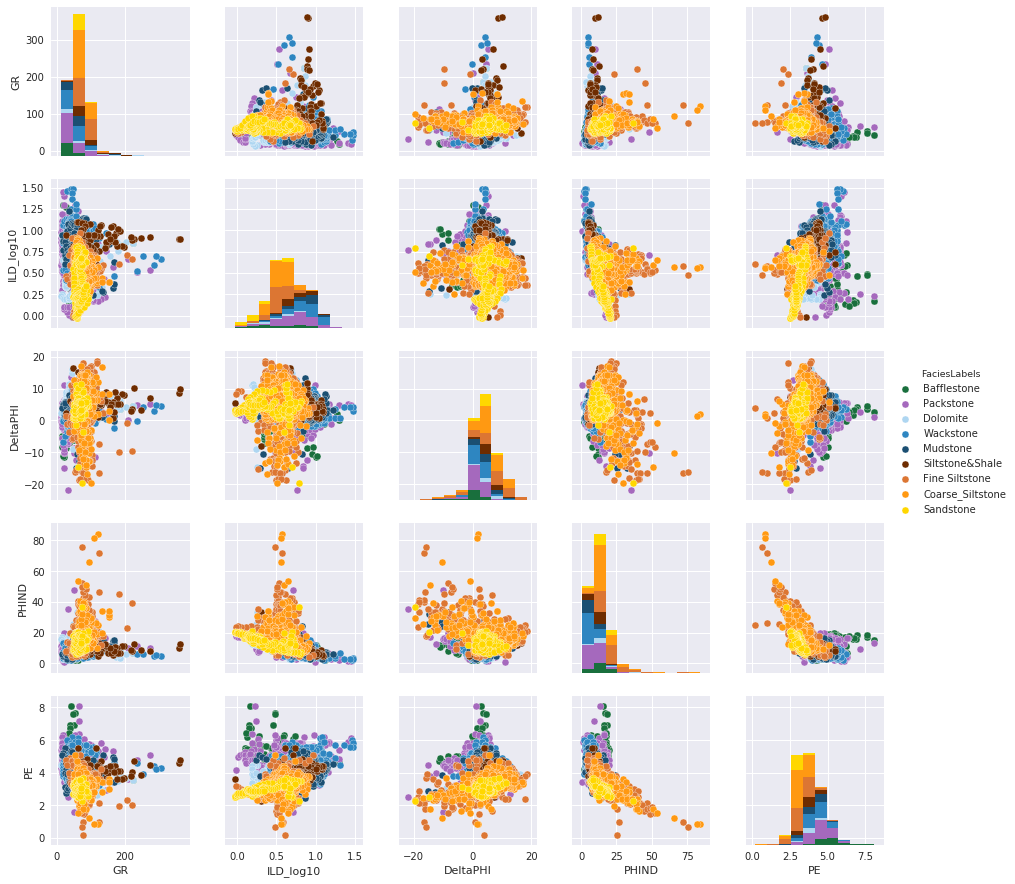

In [251]:
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

In [252]:
#GR
#Resistivity_Log(ILD_log10[ohm-m])
#PE (b/e-)
#Neutron-density-Porosity diff (DeltaPHI)
#Average Neutron-density-Porosity diff (PHIND)

#Non-Marine (NM_M)
#Relative-Position (RELPOS)

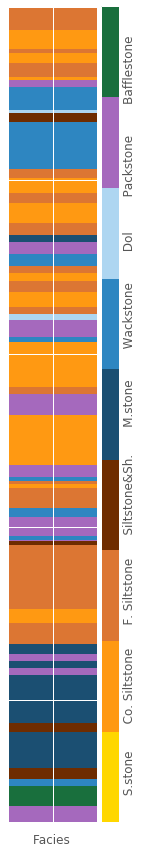

In [253]:
def Facies_Log (logs, facies_colors):
        logs = logs.sort_values(by='Depth')
        color_faceis=colors.ListedColormap(facies_colors[0:len(facies_colors)],'indexed')
        Top=logs.Depth.min()
        Bot=logs.Depth.max()
        cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
        f, xaxis = plt.subplots(figsize = (2,15))
        im=xaxis.imshow(cluster, interpolation='none',  aspect='auto',    cmap=color_faceis,vmin=1,vmax=9)     
        divider = make_axes_locatable(xaxis)
        cax = divider.append_axes("right", size="20%", pad=0.05)
        cbar=plt.colorbar(im, cax=cax)
        cbar.set_label((6*' ').join([' S.stone ', 'Co. Siltstone', 'F. Siltstone', 
                                'Siltstone&Sh.', ' M.stone ', ' Wackstone ', ' Dol  ', 
                                ' Packstone ', ' Bafflestone ']))
        cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
        xaxis.set_xlabel("Facies")
        xaxis.set_yticklabels([]);
        xaxis.set_xticklabels([])
        xaxis.figure.savefig('temp.png')

fig=Facies_Log(
    data[data['Well Name'] == 'Blackfoot1A'],
    facies_colors)



In [254]:
from bokeh.models import HoverTool
from bokeh.models.glyphs import ImageURL

from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
output_notebook()
TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select,lasso_select"
hover = HoverTool()

Loading BokehJS ...

In [255]:

def Facies_Log (logs, facies_colors):
    color_faceis=colors.ListedColormap(facies_colors[0:len(facies_colors)])
    output_notebook()
    logs=logs.sort_values(by='Depth')
    ymax = logs.Depth.min()
    ymin = logs.Depth.max()
    
# Tracks with four traces
    t1 = bk.plotting.figure(title='GR (GAPI)',plot_width=220, plot_height=750, tools=TOOLS,y_range=(ymin, ymax), x_axis_location='above')
    t1.line(x=logs.GR, y=logs.Depth, color='red')
    hover.tooltips = [  ("(GR,Depth)", "($x, $y)")]
    t1.tools.append(hover)

    t2 = bk.plotting.figure(title='ILD_log10 (ohm-m)', plot_width=220, plot_height=750, tools=TOOLS,y_range=(ymin, ymax),x_axis_location='above')
    t2.axis.axis_label_standoff=100
    t2.line(x=logs.ILD_log10, y=logs.Depth, color='blue')
    tooltips2=HoverTool(tooltips=[("(ILD,Depth)", "($x, $y)")])
    t2.tools.append(tooltips2)
    
    t3 = bk.plotting.figure(title='PE (b/e-)', plot_width=220, plot_height=750, tools=TOOLS,y_range=(ymin, ymax),x_axis_location='above')
    t3.axis.axis_label_standoff=100
    t3.line(x=logs.PE, y=logs.Depth, color='green')
    tooltips3=HoverTool(tooltips=[("(PE,Depth)", "($x, $y)")])
    t3.tools.append(tooltips3)
    
    t4 = bk.plotting.figure(title='DeltaPHI, PHIND', plot_width=220, plot_height=750, tools=TOOLS,y_range=(ymin, ymax),x_axis_location='above')
    t4.extra_x_ranges={'DeltaPHI':Range1d(start=4, end=16)}
    t4.add_layout(LinearAxis(x_range_name='DeltaPHI'), 'above')
    t4.line(x=logs.DeltaPHI, y=logs.Depth, color='black')
    t4.line(x=logs.PHIND, y=logs.Depth, color='orange')
    tooltips4=HoverTool(tooltips=[("(DeltaPHI,PHIND,Depth)", "($x, @PHIND,$y)")])
    t4.tools.append(tooltips4)  
    
    t5 = bk.plotting.figure(title='RELPOS, Nm_m', plot_width=220, plot_height=750, tools=TOOLS,y_range=(ymin, ymax),x_axis_location='above')
    t5.extra_x_ranges={'DeltaPHI':Range1d(start=4, end=16)}
    t5.add_layout(LinearAxis(x_range_name='DeltaPHI'), 'above')
    t5.line(x=logs.RELPOS, y=logs.Depth, color='yellow')
    t5.line(x=logs.NM_M, y=logs.Depth, color='red')
    tooltips5=HoverTool(tooltips=[("(RELPOS,NM_M,Depth)", "($x, @NM_M,$y)")])
    t5.tools.append(tooltips5) 
    
  





#     t6 = bk.plotting.figure(title='RELPOS, Nm_m', plot_width=220, plot_height=750, tools=TOOLS,y_range=(ymin, ymax),x_axis_location='above')
#     t6.extra_x_ranges={'DeltaPHI':Range1d(start=4, end=16)}
#     t6.add_layout(LinearAxis(x_range_name='DeltaPHI'), 'above')
#     t6.line(x=logs.RELPOS, y=logs.Depth, color='yellow')
#     t6.line(x=logs.NM_M, y=logs.Depth, color='red')
#     tooltips5=HoverTool(tooltips=[("(RELPOS,NM_M,Depth)", "($x, @NM_M,$y)")])
#     t6.tools.append(tooltips6) 
    

    url = "https://bokeh.pydata.org/en/latest/_static/images/logo.png"
    image1 = ImageURL(url="url", x="x1", y="y1", w="w1", h="h1", anchor="center")
    N=5
    source = ColumnDataSource(dict(
    url = [url]*N,
    x1  = np.linspace(  0, 150, N),
    y1  = np.linspace(  0, 150, N),
    w1  = np.linspace( 10,  50, N),
    h1  = np.linspace( 10,  50, N),
    x2  = np.linspace(-50, 150, N),
    y2  = np.linspace(  0, 200, N),
))
    t7=bk.plotting.figure(title='Facies',plot_width=220, plot_height=750, tools=TOOLS,x_axis_location='above')
    t7.add_glyph(source, image1)
    #t7.image(image=[logs.Facies],x=0, y=0, dw=10, dh=10)

    
    
    
    
    #im=.imshow(cluster, interpolation='none', aspect='auto',  cmap=color_faceis,vmin=1,vmax=9)
                
        
    #cbar=bk.plotting.colorbar(im)
    
    
    
        
    show(row(t1,t2,t3,t4,t5,t7))


    
    
    

In [256]:
Facies_Log(data[data['Well Name'] == 'Blackfoot1A'],facies_colors)

Loading BokehJS ...

In [257]:
#output_file("taylor.html")


# Tracks with four traces
# https://bokeh.pydata.org/en/latest/docs/user_guide/interaction/linking.html
t1 = bk.plotting.figure(title='CALI (IN), GR (GAPI)',
            extra_x_ranges={'CALI (IN)': Range1d(start=0, end=16),
                           'GR (GAPI)': Range1d(start=0, end=250),
                           },
            plot_width=250, plot_height=750,
            y_range=(ymin, ymax), 
            x_axis_location='above'
            )


t1.tools.append(TOOLTIPS1)
t1.extra_x_ranges = {'CALI (IN)': Range1d(start=0, end=16)}
t1.add_layout(LinearAxis(x_range_name='CALI (IN)'), 'above')


t1.line(x=dfB['GR (GAPI)'], y=dfB['DEPTH (FT)'], color='white')
t1.line(x=dfB['CALI (IN)'], y=dfB['DEPTH (FT)'], x_range_name='CALI (IN)', color='black')
#Track 2
t2 = bk.plotting.figure(title='NPHISS, RHOB (G/C3)',
            plot_width=250, plot_height=750,
            y_range=t1.y_range, 
            x_axis_location='above'
            )

t2.axis.axis_label_standoff=100
t2.line(x=dfB['NPHISS'], y=dfB['DEPTH (FT)'], color='red')
t2.line(x=dfB['RHOB (G/C3)'], y=dfB['DEPTH (FT)'], color='blue')

# #Track 3
t3 = bk.plotting.figure(title='DeltaPHI (OHMM), SP (MV), RFOC (OHMM)', 
            plot_width=250, plot_height=750,
            y_range=t1.y_range, 
            x_axis_location='above')

t3.multi_line(xs=[dfB['RILD (OHMM)'], dfB['SP (MV)'], dfB['RFOC (OHMM)']], ys=[dfB['DEPTH (FT)'], dfB['DEPTH (FT)'], dfB['DEPTH (FT)']], color=['black','green','yellow'])

# #Track 4
# t4 = bk.plotting.figure(title='RM_HRLT, RT_HRLT, DTCO, DTST',
#             plot_width=250, plot_height=750,
#             y_range=t1.y_range, 
#             x_axis_location='above')
# t4.multi_line(xs=[dfB['RM_HRLT'], dfB['RT_HRLT'], dfB['DTCO'], dfB['DTST']], ys=[dfB['depth'], dfB['depth'], dfB['depth'], dfB['depth']], color=['black','blue','red','green'])
# show(row(t1, t2, t3, t4))

show(row(t1, t2, t3))



NameError: name 'ymin' is not defined

In [258]:
def Facies_Log (logs, facies_colors):
        logs = logs.sort_values(by='Depth')
        color_faceis=colors.ListedColormap(facies_colors[0:len(facies_colors)],'indexed')

        Top=logs.Depth.min()
        Bot=logs.Depth.max()
        cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)

        
        f, xaxis = plt.subplots(nrows=1,ncols=8, figsize=(8,12))
        xaxis[0].plot(logs.GR,logs.Depth,'#32CD32')
        xaxis[0].set_xlabel("GR")
        xaxis[1].plot(logs.DeltaPHI,logs.Depth,'#7FFF00')
        xaxis[1].set_xlabel("DeltaPHI")
        xaxis[2].plot(logs.NM_M,logs.Depth,'#F8F8FF')
        xaxis[2].set_xlabel("NM_M")
        xaxis[3].plot(logs.PHIND,logs.Depth,'#FF0000')
        xaxis[3].set_xlabel("PHIND")
        xaxis[4].plot(logs.ILD_log10,logs.Depth,'#FFFF00')
        xaxis[4].set_xlabel("ILD_log10")
        xaxis[5].plot(logs.RELPOS,logs.Depth,'#00FFFF')
        xaxis[5].set_xlabel("RELPOS")
        xaxis[6].plot(logs.PE,logs.Depth,'#7cfc00')
        xaxis[6].set_xlabel("PE")
        im=xaxis[7].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=color_faceis,vmin=1,vmax=9)
        
        divider = make_axes_locatable(xaxis[7])
        cax = divider.append_axes("right", size="20%", pad=0.05)
        cbar=plt.colorbar(im, cax=cax)
        cbar.set_label((6*' ').join([' S.stone ', 'Co. Siltstone', 'F. Siltstone', 
                                'Siltstone&Sh.', ' M.stone ', ' Wackstone ', ' Dol  ', 
                                ' Packstone ', ' Bafflestone ']))
        cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
        
   

        
        xaxis[7].set_xlabel("Facies")

        
        for i in range(len(xaxis)-1):
            xaxis[i].set_ylim(Top,Bot)
            xaxis[i].invert_yaxis()
            xaxis[i].grid(linestyle='--')
            xaxis[i].locator_params(axis='x', nbins=3)
        xaxis[1].set_yticklabels([]); xaxis[2].set_yticklabels([]); xaxis[3].set_yticklabels([])
        xaxis[4].set_yticklabels([]); xaxis[5].set_yticklabels([]);xaxis[6].set_yticklabels([]);xaxis[7].set_yticklabels([]);
        xaxis[7].set_xticklabels([])
        f.suptitle(logs.iloc[1]['Well Name'], fontsize=14,y=0.9)
        

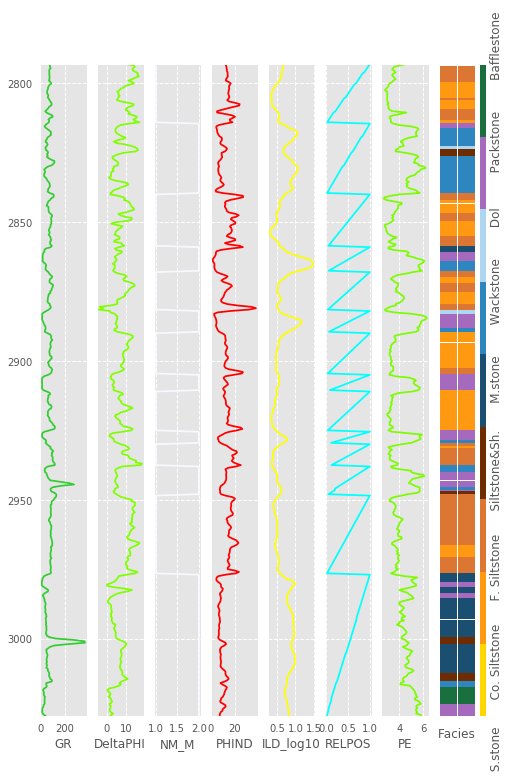

In [259]:
Facies_Log(
    data[data['Well Name'] == 'Blackfoot1A'],
    facies_colors)

In [260]:
#sns.pairplot(feature_vectors([['GR','ILD_log10','DeltaPHI','PHIND','PE','NM_M',]],axis=1),hue='FaciesLabels', palette=facies_map,hue_order=list(reversed(Facies_labels)))

In [261]:
correct_facies_labels = data['Facies'].values
features=['GR', 'ILD_log10', 'DeltaPHI', 'PHIND','PE']
feature_vectors=data[features]
scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

In [262]:
X_train, X_cv, y_train, y_cv =  train_test_split(scaled_features, correct_facies_labels, test_size=0.05, random_state=42)

In [263]:
clf2 = svm.SVC(C=0.1, gamma=1)
clf2.fit(X_train, y_train) 
y_hat = clf2.predict(X_cv)

conf=    confusion_matrix(y_cv,y_hat)
print(confusion_matrix(y_cv,y_hat))
print(classification_report(y_cv,y_hat))


[[ 8  7  1  0  0  0  0  0  0]
 [ 0 17 10  0  0  1  0  1  0]
 [ 0  2 11  0  0  0  0  1  0]
 [ 0  3  1  0  0  1  0  2  0]
 [ 0  1  0  0  0 14  0  3  0]
 [ 0  2  1  0  0 11  0  9  0]
 [ 0  1  0  0  0  0  0  2  0]
 [ 0  2  0  0  0  3  0 18  0]
 [ 0  0  0  0  0  0  0  3  4]]
             precision    recall  f1-score   support

          1       1.00      0.50      0.67        16
          2       0.49      0.59      0.53        29
          3       0.46      0.79      0.58        14
          4       0.00      0.00      0.00         7
          5       0.00      0.00      0.00        18
          6       0.37      0.48      0.42        23
          7       0.00      0.00      0.00         3
          8       0.46      0.78      0.58        23
          9       1.00      0.57      0.73         7

avg / total       0.45      0.49      0.44       140



/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [264]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

In [265]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [266]:
print( accuracy(conf))
print  (accuracy_adjacent(conf, adjacent_facies))

0.4928571428571429
0.85


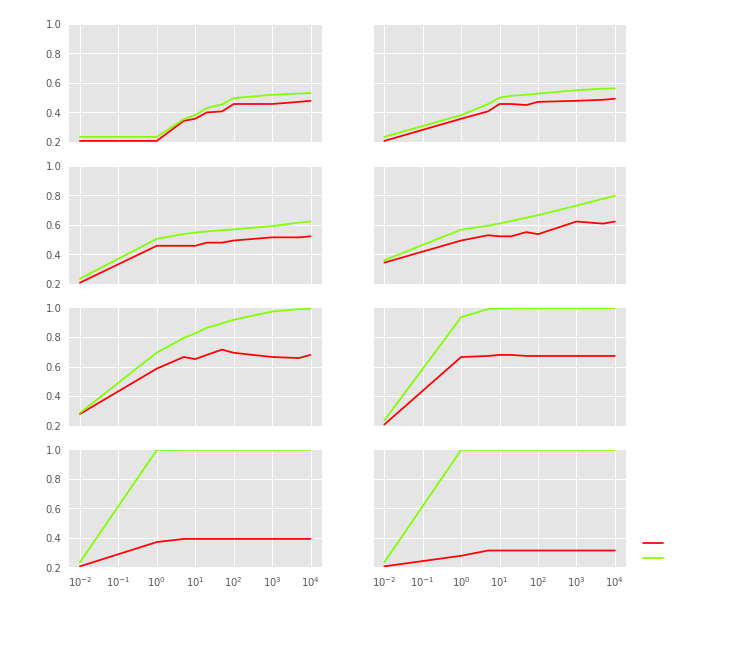

In [267]:
do_model_selection = True

if do_model_selection:
    C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
    gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10,50,100])
    
    param_fig, ax = plt.subplots(4, 2, sharex='col', sharey='row',figsize=(10,10))
    plot_number = 0
    
    for outer_ind, gamma_value in enumerate(gamma_range):
        row=int(plot_number/2)
        column=int(plot_number%2)
        cv_errors=np.zeros(C_range.shape)
        train_errors=np.zeros(C_range.shape)
        
        for index, c_value in enumerate (C_range):
            clf = svm.SVC(C=c_value, gamma=gamma_value)
            clf.fit(X_train,y_train)
            
            train_conf = confusion_matrix(y_train, clf.predict(X_train))
            cv_conf=confusion_matrix(y_cv, clf.predict(X_cv))
            
            
            cv_errors[index]=accuracy(cv_conf)
            train_errors[index]=accuracy(train_conf)
        axes=ax[row, column]
        axes.set_title('Gamma= %g' %gamma_value)
        axes.semilogx(C_range,cv_errors, '#FF0000',label='CV error')
        axes.semilogx(C_range, train_errors ,'#7FFF00',label='Train error')
        plot_number +=1
        axes.set_ylim([0.2,1])
        
        
    axes.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    param_fig.text(0.5, 0.03, 'C value', ha='center',
             fontsize=14)
             
    param_fig.text(0.04, 0.5, 'Classification Accuracy', va='center', 
             rotation='vertical', fontsize=14)
        
# ,'#7FFF00'
 #       ,'#FF0000'

In [268]:
clf2 = svm.SVC(C=50, gamma=1)
clf2.fit(X_train, y_train) 
y_hat = clf2.predict(X_cv)
    
conf=confusion_matrix(y_cv,y_hat)
print(confusion_matrix(y_cv,y_hat))
print(classification_report(y_cv,y_hat))


[[12  2  1  0  0  0  0  1  0]
 [ 0 27  1  1  0  0  0  0  0]
 [ 0  3 10  0  1  0  0  0  0]
 [ 0  1  1  3  0  0  0  2  0]
 [ 0  0  0  2  8  6  0  2  0]
 [ 0  0  0  1  0 16  0  6  0]
 [ 0  1  0  0  1  0  1  0  0]
 [ 0  0  0  0  2  4  0 16  1]
 [ 0  0  0  0  0  0  0  0  7]]
             precision    recall  f1-score   support

          1       1.00      0.75      0.86        16
          2       0.79      0.93      0.86        29
          3       0.77      0.71      0.74        14
          4       0.43      0.43      0.43         7
          5       0.67      0.44      0.53        18
          6       0.62      0.70      0.65        23
          7       1.00      0.33      0.50         3
          8       0.59      0.70      0.64        23
          9       0.88      1.00      0.93         7

avg / total       0.73      0.71      0.71       140



In [269]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc



In [270]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [271]:
print( accuracy(conf))
print  (accuracy_adjacent(conf, adjacent_facies))

0.7142857142857143
0.8928571428571429


In [389]:
clf3 = svm.SVC(C=92, gamma=0.01)
clf3.fit(X_train, y_train) 
y_hat = clf3.predict(X_test)
#100 0.01
y_pred=y_hat

conf=confusion_matrix(y_test,y_hat)
print(confusion_matrix(y_test,y_hat))
print(classification_report(y_test,y_hat))

[[ 1 80  1  0  0  5  0  2  0]
 [ 0 69 14  0  0  6  0  0  0]
 [ 0 37 68  3  0  6  0  3  0]
 [ 0  0  0  1  0  5  0  1  0]
 [ 0  0  0  9  1  6  0  3  0]
 [ 0  1  0  2  3 50  0 13  2]
 [ 0  0  0  0  1  0  8  8  0]
 [ 0  0  1  0  5 11  1 21  1]
 [ 0  0  0  0  0  0  0  0  0]]
             precision    recall  f1-score   support

          1       1.00      0.01      0.02        89
          2       0.37      0.78      0.50        89
          3       0.81      0.58      0.68       117
          4       0.07      0.14      0.09         7
          5       0.10      0.05      0.07        19
          6       0.56      0.70      0.62        71
          7       0.89      0.47      0.62        17
          8       0.41      0.53      0.46        40
          9       0.00      0.00      0.00         0

avg / total       0.65      0.49      0.45       449



/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [273]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

print( accuracy(conf))
print  (accuracy_adjacent(conf, adjacent_facies))

0.48997772828507796
0.8975501113585747


In [358]:
scores = [0]*200
for i in range(200):
    clf3 = RandomForestClassifier(n_estimators=5)
    clf3.fit(X_train, y_train)
    y_pred = clf3.predict(X_cv)
    scores[i] = metrics.accuracy_score(y_cv, y_pred)
    
    #9 67, 8 68, 
scores = np.array(scores)
print('mean: ',scores.max())
print('avg: ',scores.mean())
print(clf3.feature_importances_)
print(clf3)

conf=confusion_matrix(y_cv,y_pred)
print(confusion_matrix(y_cv,y_pred))
print(classification_report(y_cv,y_pred))

mean:  0.6857142857142857
avg:  0.6183571428571428
[0.22010645 0.20559869 0.16373703 0.19518797 0.21536986]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
[[10  4  1  0  1  0  0  0  0]
 [ 1 21  5  1  0  1  0  0  0]
 [ 1  4  9  0  0  0  0  0  0]
 [ 0  1  2  3  0  0  0  1  0]
 [ 0  1  0  2  9  4  0  2  0]
 [ 0  2  0  2  5 12  0  2  0]
 [ 0  1  0  0  0  0  2  0  0]
 [ 0  0  2  0  1  3  0 17  0]
 [ 0  0  0  0  0  0  0  0  7]]
             precision    recall  f1-score   support

          1       0.83      0.62      0.71        16
          2       0.62      0.72      0.67        29
          3       0.47      0.64      0.5

In [359]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

print( accuracy(conf))
print  (accuracy_adjacent(conf, adjacent_facies))

0.6428571428571429
0.8571428571428571


In [369]:
scores = [0]*200
for i in range(200):
    clf4 = RandomForestClassifier(n_estimators=9)
    clf4.fit(X_train, y_train)
    y_pred = clf4.predict(X_test)
    scores[i] = metrics.accuracy_score(y_test, y_pred)
    
    
scores = np.array(scores)
print('mean: ',scores.max())
print('avg: ',scores.mean())
print(clf4.feature_importances_)
print(clf4)

conf=confusion_matrix(y_test,y_pred)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

mean:  0.46993318485523383
avg:  0.41612472160356345
[0.24511741 0.2153995  0.15231251 0.18673825 0.20043233]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
[[13 66  3  0  1  1  0  5  0]
 [ 8 58 10  3  2  8  0  0  0]
 [ 1 40 56  8  3  6  0  3  0]
 [ 0  0  0  1  0  5  0  1  0]
 [ 0  0  0  0  2 13  2  2  0]
 [ 0  0  0  1 12 31  0 27  0]
 [ 1  0  0  1  0  0  7  8  0]
 [ 0  0  1  0  1 13  0 22  3]
 [ 0  0  0  0  0  0  0  0  0]]
             precision    recall  f1-score   support

          1       0.57      0.15      0.23        89
          2       0.35      0.65      0.46        89
          3       0.80      0.48      0

/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [370]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

print( accuracy(conf))
print  (accuracy_adjacent(conf, adjacent_facies))

0.42316258351893093
0.8685968819599109


In [292]:
from sklearn.neighbors import KNeighborsClassifier
ks = [1,2,3,4,5,6,7,8,9,10,15,18,19,20,21,22,30,32,33,34,45,48,50,100]
def get_knn_validation_scores(ks, model_features, model_labels, validation_features, validation_labels):
    
    d= dict()
    for k in ks:
      knn = KNeighborsClassifier(n_neighbors=k)
      knn.fit(validation_features, validation_labels)
      validationPredictions = knn.predict(validation_features)
      f1 = f1_score(validation_labels, validationPredictions, average="weighted")
      d[k] = f1 
    return d

In [294]:
training_scores = get_knn_training_scores(ks, X_train, y_train)
validation_scores = get_knn_validation_scores(ks, X_train, y_train, X_cv, y_cv)

/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/c

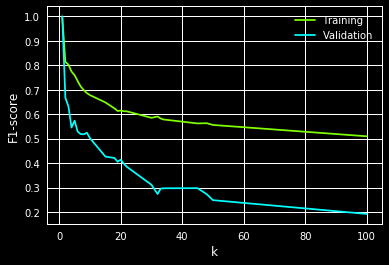

In [295]:
plt.style.use(['dark_background'])
pd.Series(training_scores ,name="Training").plot(kind="line",color='#7FFF00')
pd.Series(validation_scores,name="Validation").plot(kind="line", color='#00FFFF')
plt.legend()
plt.xlabel("k")
plt.ylabel("F1-score")
plt.show()

In [320]:
scores = []
from sklearn.neighbors import KNeighborsClassifier
clf5= KNeighborsClassifier(n_neighbors=1)
clf5.fit(X_train, y_train)
y_pred = clf5.predict(X_cv)
scores = metrics.accuracy_score(y_cv, y_pred)
#10>>44,,,12>>44,,27>>44,28,29,31
scores = np.array(scores)
print('mean: ',scores.max())
print('avg: ',scores.mean())
#print(clf5.feature_importances_)
print(clf5)
conf=confusion_matrix(y_cv,y_pred)
print(confusion_matrix(y_cv,y_pred))
print(classification_report(y_cv,y_pred))


mean:  0.6928571428571428
avg:  0.6928571428571428
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
[[ 9  4  2  1  0  0  0  0  0]
 [ 0 26  1  2  0  0  0  0  0]
 [ 0  4  9  1  0  0  0  0  0]
 [ 0  1  0  3  0  2  0  1  0]
 [ 0  0  0  3  7  5  0  3  0]
 [ 0  0  0  2  0 20  0  0  1]
 [ 0  1  0  0  1  0  1  0  0]
 [ 0  0  0  1  1  4  0 15  2]
 [ 0  0  0  0  0  0  0  0  7]]
             precision    recall  f1-score   support

          1       1.00      0.56      0.72        16
          2       0.72      0.90      0.80        29
          3       0.75      0.64      0.69        14
          4       0.23      0.43      0.30         7
          5       0.78      0.39      0.52        18
          6       0.65      0.87      0.74        23
          7       1.00      0.33      0.50         3
          8       0.79      0.65      0.71        23
          9       0.70      1.00    

In [317]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))
print( accuracy(conf))
print  (accuracy_adjacent(conf, adjacent_facies))



0.6928571428571428
0.8571428571428571


In [343]:
scores = []
from sklearn.neighbors import KNeighborsClassifier
clf5= KNeighborsClassifier(n_neighbors=68)
clf5.fit(X_train, y_train)
y_pred = clf5.predict(X_test)
scores = metrics.accuracy_score(y_test, y_pred)
#10>>44,,,12>>44,,27>>44,28,29,31
scores = np.array(scores)
print('mean: ',scores.max())
print('avg: ',scores.mean())
#print(clf5.feature_importances_)
print(clf5)
conf=confusion_matrix(y_test,y_pred)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))


mean:  0.46325167037861914
avg:  0.46325167037861914
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=68, p=2,
           weights='uniform')
[[ 5 77  2  0  0  5  0  0  0]
 [ 1 69 14  0  2  3  0  0  0]
 [ 0 39 69  2  2  4  0  1  0]
 [ 0  0  0  1  1  4  0  1  0]
 [ 0  0  0  9  0  5  0  5  0]
 [ 0  1  0  2  9 43  0 16  0]
 [ 8  1  0  0  0  0  0  8  0]
 [ 0  0  1  2  1 13  0 21  2]
 [ 0  0  0  0  0  0  0  0  0]]
             precision    recall  f1-score   support

          1       0.36      0.06      0.10        89
          2       0.37      0.78      0.50        89
          3       0.80      0.59      0.68       117
          4       0.06      0.14      0.09         7
          5       0.00      0.00      0.00        19
          6       0.56      0.61      0.58        71
          7       0.00      0.00      0.00        17
          8       0.40      0.53      0.46        40
          9       0.00      0.00 

/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [344]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))
print( accuracy(conf))
print  (accuracy_adjacent(conf, adjacent_facies))

0.46325167037861914
0.8953229398663697


In [390]:
test_well['Prediction'] = y_pred

In [391]:
def Comparison_Facies (logs, compadre, facies_colors):
        logs = logs.sort_values(by='Depth')
        color_faceis=colors.ListedColormap(facies_colors[0:len(facies_colors)])

        Top=logs.Depth.min()
        Bot=logs.Depth.max()
        cluster1=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
        cluster2=np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)


        
        f, xaxis = plt.subplots(nrows=1,ncols=9, figsize=(8,12))
        xaxis[0].plot(logs.GR,logs.Depth,'#32CD32')
        xaxis[0].set_xlabel("GR")
        xaxis[1].plot(logs.DeltaPHI,logs.Depth,'#7FFF00')
        xaxis[1].set_xlabel("DeltaPHI")
        xaxis[2].plot(logs.NM_M,logs.Depth,'#F8F8FF')
        xaxis[2].set_xlabel("NM_M")
        xaxis[3].plot(logs.PHIND,logs.Depth,'#FF0000')
        xaxis[3].set_xlabel("PHIND")
        xaxis[4].plot(logs.ILD_log10,logs.Depth,'#FFFF00')
        xaxis[4].set_xlabel("ILD_log10")
        xaxis[5].plot(logs.RELPOS,logs.Depth,'#00FFFF')
        xaxis[5].set_xlabel("RELPOS")
        xaxis[6].plot(logs.PE,logs.Depth,'#7cfc00')
        xaxis[6].set_xlabel("PE")
        
        im=xaxis[7].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=color_faceis,vmin=1,vmax=9)
        xaxis[7].set_xlabel("Facies")
        
        
        im2=xaxis[8].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=color_faceis,vmin=1,vmax=9)
        xaxis[8].set_xlabel(compadre)        

        
        divider = make_axes_locatable(xaxis[8])
        cax = divider.append_axes("right", size="20%", pad=0.05)
        cbar=plt.colorbar(im, cax=cax)
        cbar.set_label((12*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
        cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
        
        
        
        
        for i in range(len(xaxis)-2):
            xaxis[i].set_ylim(Top,Bot)
            xaxis[i].invert_yaxis()
            xaxis[i].grid()
            xaxis[i].locator_params(axis='x', nbins=3)
        xaxis[1].set_yticklabels([]); xaxis[2].set_yticklabels([]); xaxis[3].set_yticklabels([])
        xaxis[4].set_yticklabels([]); xaxis[5].set_yticklabels([]);xaxis[6].set_yticklabels([]);xaxis[7].set_yticklabels([]);xaxis[8].set_yticklabels([])
        xaxis[7].set_xticklabels([])
        xaxis[8].set_xticklabels([])

        f.suptitle(logs.iloc[1]['Well Name'], fontsize=14,y=0.9)

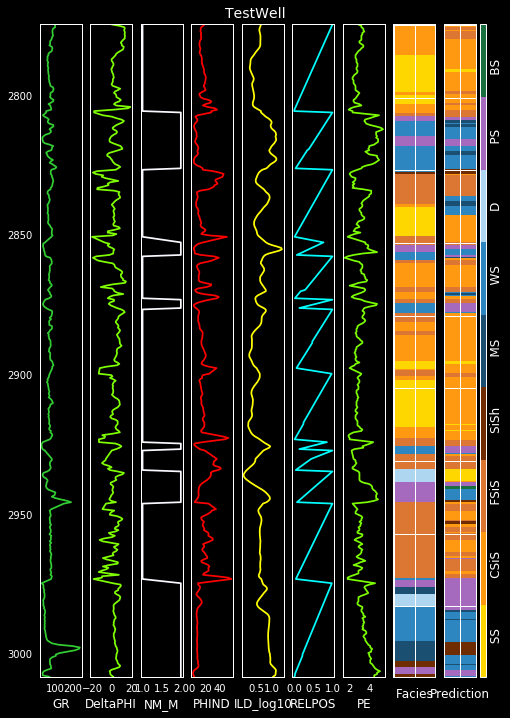

In [347]:
Comparison_Facies(test_well, 'Prediction', facies_colors)

